##Supervised learning

link to colab
https://colab.research.google.com/drive/1kZ-Zt13adsBDhupRH96XB1uGvUF5-LCN

In [0]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

This analasys is made to be run on either the dataset where we have reduced the data with NMF and PCA in the unsupervised notebook, or on the data that has noly been cleaned in the data cleaning notebook.

In [0]:
!wget https://www.dropbox.com/s/638sxxn26qi6sw4/Final_2.csv?dl=0            #Data that has been reduced with NMF
!wget https://www.dropbox.com/s/jchj5huazph1htx/out_dataframe-8.csv?dl=0    #Data that has only been cleaned

--2019-09-26 19:14:19--  https://www.dropbox.com/s/638sxxn26qi6sw4/Final_2.csv?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.81.1, 2620:100:6031:1::a27d:5101
Connecting to www.dropbox.com (www.dropbox.com)|162.125.81.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/638sxxn26qi6sw4/Final_2.csv [following]
--2019-09-26 19:14:20--  https://www.dropbox.com/s/raw/638sxxn26qi6sw4/Final_2.csv
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc6a06b13431d4b73d3bd42f0ab0.dl.dropboxusercontent.com/cd/0/inline/ApSDGMehME0moA1hFTBHAXfGQjEXCwEZgvH4ZEnJphxPiCkElnnYHGyNsmRhqnknpDdOA5ywpxqRzI7zYdumgaSWU7t2aokLm2TVoBw4MyVaqbh5cRqlGnqBg6sWVnLfjaM/file# [following]
--2019-09-26 19:14:20--  https://uc6a06b13431d4b73d3bd42f0ab0.dl.dropboxusercontent.com/cd/0/inline/ApSDGMehME0moA1hFTBHAXfGQjEXCwEZgvH4ZEnJphxPiCkElnnYHGyNsmRhqnknpDdOA5ywpxqRzI7zYdumgaSWU7t2aokLm2TVoBw4MyVaq

Load the data that has been reduced with and PCA:

In [0]:
#Loading the data that has been reduced in the unsupervised part
df_sl=pd.read_csv('Final_2.csv?dl=0',index_col=0)
df_sl=df_sl.drop(columns=['clusters'])


OR load, select and scale the non-reduced data:

In [0]:
# #Loading the original data and scaling it with MinMaxScaler
# df_sl=pd.read_csv('out_dataframe-8.csv?dl=0',index_col=0)
# df_sl=df_sl.drop(columns=['timestamp','country_txt','gname'])
# from sklearn.preprocessing import MinMaxScaler
# MMscaler = MinMaxScaler()
# scale=MMscaler.fit_transform(df_sl)
# df_sl=pd.DataFrame(scale,columns=df_sl.columns)

### Splitting the data
We do this to have seperate data to train/fit the models on and to test the models on.

In [0]:
from sklearn.model_selection import train_test_split

In [0]:
y=df_sl['nkill']
X=df_sl.drop(columns=['nkill'])

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42)

## Applying regression models
We import cross_validate to make the cross validation show both r^2 and mean squarred error. We are going to run k-fold cross validation on our models with 5 folds.
We also import mean_squarred_error seperatly to find the mean squared error when we use the models to predict the test data.

In [0]:
from sklearn.model_selection import cross_validate
from sklearn.metrics import mean_squared_error

### Linear Regression

The first model we will try to fit on the data is a simple linear regression, just to use it as a benchmark.

In [0]:
from sklearn.linear_model import LinearRegression
model_LR = LinearRegression()

#Fitting the model
model_LR.fit(X_train, y_train)

#Cross-validation scores for 5 folds
scores = cross_validate(model_LR, X_train, y_train, cv = 5, scoring=['r2','neg_mean_squared_error'])
print(pd.DataFrame(scores))

   fit_time  score_time   test_r2  test_neg_mean_squared_error
0  0.006093    0.003041 -0.024787                    -3.627635
1  0.005070    0.002688  0.052142                   -47.534986
2  0.004663    0.002756 -0.110571                    -0.563777
3  0.004732    0.002884  0.442119                    -4.052944
4  0.004503    0.002868  0.296717                    -2.947313


In [0]:
# Calculating performance on the test sample
r2_LR=model_LR.score(X_test, y_test)
mse_LR= mean_squared_error(y_test,model_LR.predict(X_test))

print('\n',"R2 for the Linear Regression performed on the test sample: ",r2_LR)
print("Mean squared error for the test sample is: ",mse_LR)


 R2 for the Linear Regression performed on the test sample:  0.005157111020433147
Mean squared error for the test sample is:  5.481745707104172


Reduced data: r2 at 0.005 is bad, so is a mse at 5.48.

Non-reduced data: r2 at 0.35 is not too great, a mse at 2.60e^-5 is in it self great but together with the low r2 it suggest there is a problem.

### Catboost Regressor

Next, we are going to use a catboost regressor, in order to see whether a decision tree-based model yields a different result. The task is executed on GPU for computational power reasons. The optimal depth ranges from 4 to 10, according to the official documentation. A depth of 8 yielded slightly better results, so we decided to go with that.

In [0]:
!pip install catboost

from catboost import CatBoostRegressor
model_CB = CatBoostRegressor(task_type = 'GPU',depth=8) 

model_CB.fit(X_train, y_train)

scores = cross_validate(model_CB, X_train, y_train, cv = 5, scoring=['r2','neg_mean_squared_error'])
print(pd.DataFrame(scores))

     |████████████████████████████████| 62.5MB 45.2MB/s 
0:	learn: 3.6148610	total: 45.3ms	remaining: 45.2s
1:	learn: 3.6046009	total: 87.7ms	remaining: 43.7s
2:	learn: 3.5953134	total: 130ms	remaining: 43.3s
3:	learn: 3.5843608	total: 170ms	remaining: 42.4s
4:	learn: 3.5754745	total: 201ms	remaining: 40s
5:	learn: 3.5670151	total: 217ms	remaining: 36s
6:	learn: 3.5593258	total: 226ms	remaining: 32s
7:	learn: 3.5531163	total: 261ms	remaining: 32.3s
8:	learn: 3.5453373	total: 273ms	remaining: 30.1s
9:	learn: 3.5375187	total: 296ms	remaining: 29.3s
10:	learn: 3.5299406	total: 308ms	remaining: 27.7s
11:	learn: 3.5230849	total: 320ms	remaining: 26.4s
12:	learn: 3.5159927	total: 336ms	remaining: 25.5s
13:	learn: 3.5079276	total: 364ms	remaining: 25.6s
14:	learn: 3.5018967	total: 373ms	remaining: 24.5s
15:	learn: 3.4958170	total: 383ms	remaining: 23.6s
16:	learn: 3.4893620	total: 404ms	remaining: 23.4s
17:	learn: 3.4848404	total: 412ms	remaining: 22.5s
18:	learn: 3.4801533	total: 433ms	remai

In [0]:
r2_CB=model_CB.score(X_test, y_test)
mse_CB=mean_squared_error(y_test,model_CB.predict(X_test))

print('\n',"R2 for the Catboost Regressor: ",r2_CB)
print("Mean squared error for the test sample is: ",mse_CB)


 R2 for the Catboost Regressor:  -0.043331967559998574
Mean squared error for the test sample is:  5.748928396244525


Reduced data: a negative r2 bad, so is a mse at 5.75.

Non-reduced data: r2 at 0.32 is not too great, a mse at 2.70e^-5 is in it self great but together with the low r2 it suggest there is a problem.

### Elastic Net

In [0]:
from sklearn.linear_model import ElasticNet
model_EN=ElasticNet()

model_EN.fit(X_train, y_train)

scores = cross_validate(model_EN, X_train, y_train, cv = 5, scoring=['r2','neg_mean_squared_error'])
print(pd.DataFrame(scores))

   fit_time  score_time   test_r2  test_neg_mean_squared_error
0  0.004413    0.003000 -0.014027                    -3.589546
1  0.003879    0.002966  0.045284                   -47.878905
2  0.004101    0.003165 -0.300338                    -0.660111
3  0.003833    0.003069  0.427370                    -4.160094
4  0.004019    0.002412  0.257661                    -3.110988


In [0]:
r2_EN=model_EN.score(X_test, y_test)
mse_EN=mean_squared_error(y_test,model_EN.predict(X_test))

print('\n',"R2 for the Elastic Net Model: ",r2_EN)
print("Mean squared error for the test sample is: ",mse_EN)


 R2 for the Elastic Net Model:  -0.023728235743015972
Mean squared error for the test sample is:  5.640908653708904


Reduced data: r2 at -0.02 indicates something is wrong, this model is NOT sutid for this data. A mse at 5.64 is bad.

Non-reduced data: r2 at -1.6e^-5 indicates something is wrong, this model is NOT sutid for this data. Again a mse at 4.02e^-5 is in it self great but together with the negative r2 it suggest there is a problem.

# Visualization of regression statistics

First we save the scores from the three models in a nice dataframe, and then we also plot the data using barplots.

In [0]:
r2_list=[r2_LR,r2_CB,r2_EN]
mse_list=[mse_LR,mse_CB,mse_EN]

#Change chose here before you run the rest: 
#results_NONreduced=pd.DataFrame(list(zip(r2_list, mse_list)),columns=('R2','MSE'),index=['Lin Reg','CB Reg','Elastic Net'])
results_reduced=pd.DataFrame(list(zip(r2_list, mse_list)),columns=('R2','MSE'),index=['Lin Reg','CB Reg','Elastic Net'])

In [0]:
results=results_reduced  #chose if you want the results for the reduced or nonreduced data

results

,R2,MSE
Lin Reg,0.005157,5.481746
CB Reg,-0.043332,5.748928
Elastic Net,-0.023728,5.640909


Reduced data: So as mentioned above, non of the models seem to be good at predicting the data, but Lin Reg is the better option.

Non-reduced data: So as mentioned above, non of the models seem to be good at predicting the data.

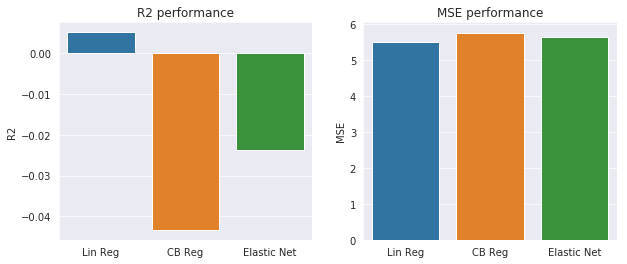

In [0]:
sns.set_style("darkgrid")
fig, ax=plt.subplots(1,2,figsize=(10,4))
sns.barplot(x=results.index.values ,y='R2',data=results,ax=ax[0]).set_title('R2 performance')
sns.barplot(x=results.index.values ,y='MSE',data=results,ax=ax[1]).set_title('MSE performance')
print(' ')# To stop it from printing random stuff

Our conclusion is that the data is not sutied to be used to predict the number of people killed by terror attacks. See more in the stakeholdder report.